# Kodowanie obrazów za pomocą "programów" w Gimpie

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
from src.coding.coding import RandomEncoder, RandomDecoder
import random
import os

IMAGES_PATH = '../data/image/scaled_images/'

def random_img():
    return random.choice(os.listdir(IMAGES_PATH))

def show_img(img_path):
    image_data = plt.imread(os.path.join(IMAGES_PATH, img_path))[:,:,:3]
    plt.imshow(image_data)
    
def calculate_loss(img_path, decoded_img):
    image_data = plt.imread(os.path.join(IMAGES_PATH, img_path))[:,:,:3]
    return np.linalg.norm(image_data - decoded_img)

Using TensorFlow backend.


In [2]:
encoder = RandomEncoder()
decoder = RandomDecoder()

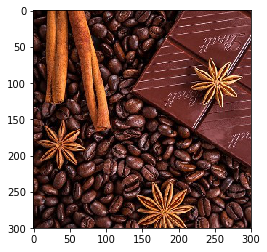

In [10]:
img_path = random_img()
show_img(img_path)

In [12]:
encoded, _ = encoder.encode(img_path, actions=10, size=50, render=True, to_bytes=True)

compressed to action vector of 484 bytes
compressed with AC to 1386 bytes
compressed in 7.601409196853638 sec


In [5]:
print(encoded[0:100])

b'\x00\x00\x00R\x00\x00\x00\x03\x00\x00\x00\x03\x00\x00\x00\x02\x00\x00\x00\x02\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x01\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00\x01'


decompressed from AC to 484 bytes
decompressed in 3.194024085998535 sec


TypeError: 'float' object is not iterable

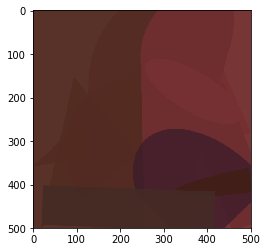

In [13]:
_, decoded_img = decoder.decode(encoded, size=500, from_bytes=True)

In [ ]:
loss = calculate_loss(img_path, decoded_img)
print(loss)

### COMPRESSION RATIO
$$0,06818 \cdot \frac{size^2}{actions}$$

Stała 0,06818 wynika z założenia reprezentacji obrazka wejściowego przez **3 B/pixel** (RGB) oraz obrazka skompresowanego przez **44 B/action** (4 bajty na numer akcji, 10 razy 4 bajty na argumenty akcji)

Przykładowo dla obrazka 100x100 i 100 akcji **compression ratio = 6,818**     

Skoro compression ratio zależy od ilości wykonanych akcji, istnieje maksymalna wartość, którą możemy użyć, aby skompresowany obrazek był mniejszy od obrazka wejściowego.   
$$maxActions=ceil(0.06818 \cdot size^2-1)$$
Przykładowo:   
obrazek 50x50 = max 170 akcji   
obrazek 100x100 = max 681 akcji        
obrazek 300x300 = max 6136 akcji

Liczbę możliwych do wykonania akcji można nieco zwiększyć poprzez zastosowanie dodatkowej kompresji na wynikowym ciągu wektorów akcji. Użyłam do tego celu gotowego kodera entropijnego wykorzystującego kodowanie arytmetyczne. Ma ono jednak sens jedynie po przekroczeniu pewnej liczby akcji, ponieważ w skompresowanym pliku przechowywana jest między innymi tablica prawdopodobieństw. Dla małych plików (mniej niż 200 akcji, ~ 8kB) kompresja spowoduje więc powstanie większego pliku niż plik wejściowy.
### COMPRESSION SPEED
![compression speed](../result/coding/encoding_time.png)

Relacja ilości akcji do czasu (100x100):
$$time = 0.55 \cdot actions + 3.47 [s]$$

![compression speed](../result/coding/encoding_time_sizes.png)

### DECOMPRESSION SPEED
![compression speed](../result/coding/decoding_time.png)

Relacja ilości akcji do czasu (100x100):
$$time = 0.01 \cdot actions + 2.6 [s]$$

![compression speed](../result/coding/decoding_time_sizes.png)

Zwiększając liczbę akcji (zmniejszając compression loss) czas kompresji rośnie około **5.5 razy szybciej** niż czas dekompresji.   
Zwiększając rozmiar kodowanego obrazka czas kompresji rośnie w dużym przybliżeniu około **28 razy szybciej** niż czas dekompresji.

#### Dekompresja do dowolnego rozmiaru

### COMPRESSION LOSS
Za miarę straty kompresji przyjęłam dystans l2:
![euclidean distance](https://wikimedia.org/api/rest_v1/media/math/render/svg/795b967db2917cdde7c2da2d1ee327eb673276c0)




In [7]:
import tqdm

encoding_times = []
decoding_times = []

for i in tqdm.tqdm(range(100)):
    img_path = random_img()
    encoded, encoded_time = encoder.encode(img_path, actions=i, size=100, render=False, to_bytes=True)
    encoding_times.append(encoded_time)
    decoded_time = decoder.decode(encoded, size=100, from_bytes=True)
    decoding_times.append(decoded_time)

plt.clf()
plt.plot(encoding_times)
plt.xlabel('action')
plt.ylabel('time [s]')
title = 'encoding 100x100 img'
plt.title(title)
plt.savefig('../result/coding/encoding_time.png')
plt.clf()

plt.plot(decoding_times)
plt.xlabel('action')
plt.ylabel('time [s]')
title = 'decoding 100x100 img'
plt.title(title)
plt.savefig('../result/coding/decoding_time.png')
plt.clf()

  0%|          | 0/100 [00:00<?, ?it/s]

compressed to action vector of 44 bytes
compressed with AC to 1050 bytes
compressed in 3.4784095287323 sec
decompressed from AC to 44 bytes


  1%|          | 1/100 [00:06<10:06,  6.13s/it]

decompressed in 2.6297965049743652 sec
compressed to action vector of 88 bytes
compressed with AC to 1077 bytes
compressed in 4.3717474937438965 sec
decompressed from AC to 88 bytes


  2%|▏         | 2/100 [00:13<11:06,  6.80s/it]

decompressed in 3.0845837593078613 sec
compressed to action vector of 132 bytes
compressed with AC to 1114 bytes
compressed in 4.997117519378662 sec
decompressed from AC to 132 bytes


  3%|▎         | 3/100 [00:21<11:30,  7.12s/it]

decompressed in 2.743377923965454 sec
compressed to action vector of 176 bytes
compressed with AC to 1144 bytes
compressed in 4.715380668640137 sec
decompressed from AC to 176 bytes


  4%|▍         | 4/100 [00:28<11:33,  7.22s/it]

decompressed in 2.7703325748443604 sec
compressed to action vector of 220 bytes
compressed with AC to 1179 bytes
compressed in 5.648920297622681 sec
decompressed from AC to 220 bytes


  5%|▌         | 5/100 [00:37<11:58,  7.56s/it]

decompressed in 3.2804677486419678 sec
compressed to action vector of 264 bytes
compressed with AC to 1191 bytes
compressed in 6.718923091888428 sec
decompressed from AC to 264 bytes


  6%|▌         | 6/100 [00:47<12:20,  7.88s/it]

decompressed in 2.7261037826538086 sec
compressed to action vector of 308 bytes
compressed with AC to 1234 bytes
compressed in 6.38506555557251 sec
decompressed from AC to 308 bytes


  7%|▋         | 7/100 [00:56<12:33,  8.10s/it]

decompressed in 3.024477958679199 sec
compressed to action vector of 352 bytes
compressed with AC to 1277 bytes
compressed in 8.585692644119263 sec
decompressed from AC to 352 bytes


  8%|▊         | 8/100 [01:08<13:07,  8.56s/it]

decompressed in 3.1660006046295166 sec
compressed to action vector of 396 bytes
compressed with AC to 1310 bytes
compressed in 8.57326364517212 sec
decompressed from AC to 396 bytes


  9%|▉         | 9/100 [01:20<13:29,  8.89s/it]

decompressed in 2.941202402114868 sec
compressed to action vector of 440 bytes
compressed with AC to 1332 bytes
compressed in 8.097193717956543 sec
decompressed from AC to 440 bytes


 10%|█         | 10/100 [01:31<13:39,  9.10s/it]

decompressed in 2.8955624103546143 sec
compressed to action vector of 484 bytes
compressed with AC to 1381 bytes
compressed in 9.177162408828735 sec
decompressed from AC to 484 bytes


 11%|█         | 11/100 [01:43<13:53,  9.37s/it]

decompressed in 2.79251766204834 sec
compressed to action vector of 528 bytes
compressed with AC to 1409 bytes
compressed in 8.897388935089111 sec
decompressed from AC to 528 bytes


 12%|█▏        | 12/100 [01:54<14:00,  9.56s/it]

decompressed in 2.7467494010925293 sec
compressed to action vector of 572 bytes
compressed with AC to 1479 bytes
compressed in 9.219659328460693 sec
decompressed from AC to 572 bytes


 13%|█▎        | 13/100 [02:06<14:07,  9.75s/it]

decompressed in 2.7719063758850098 sec
compressed to action vector of 616 bytes
compressed with AC to 1477 bytes
compressed in 9.094385623931885 sec
decompressed from AC to 616 bytes


 14%|█▍        | 14/100 [02:18<14:11,  9.90s/it]

decompressed in 2.761215925216675 sec
compressed to action vector of 660 bytes
compressed with AC to 1515 bytes
compressed in 10.06458592414856 sec
decompressed from AC to 660 bytes


 15%|█▌        | 15/100 [02:31<14:17, 10.09s/it]

decompressed in 2.7513628005981445 sec
compressed to action vector of 704 bytes
compressed with AC to 1545 bytes
compressed in 9.533084392547607 sec
decompressed from AC to 704 bytes


 16%|█▌        | 16/100 [02:43<14:20, 10.24s/it]

decompressed in 2.864030599594116 sec
compressed to action vector of 748 bytes
compressed with AC to 1587 bytes
compressed in 10.432631492614746 sec
decompressed from AC to 748 bytes


 17%|█▋        | 17/100 [02:57<14:24, 10.41s/it]

decompressed in 2.785094738006592 sec
compressed to action vector of 792 bytes
compressed with AC to 1621 bytes
compressed in 11.124620199203491 sec
decompressed from AC to 792 bytes


 18%|█▊        | 18/100 [03:10<14:29, 10.61s/it]

decompressed in 2.782310724258423 sec
compressed to action vector of 836 bytes
compressed with AC to 1647 bytes
compressed in 11.38717007637024 sec
decompressed from AC to 836 bytes


 19%|█▉        | 19/100 [03:25<14:34, 10.80s/it]

decompressed in 2.84084415435791 sec
compressed to action vector of 880 bytes
compressed with AC to 1665 bytes
compressed in 12.595098972320557 sec
decompressed from AC to 880 bytes


 20%|██        | 20/100 [03:40<14:43, 11.04s/it]

decompressed in 3.0482075214385986 sec
compressed to action vector of 924 bytes
compressed with AC to 1715 bytes
compressed in 13.663925647735596 sec
decompressed from AC to 924 bytes


 21%|██        | 21/100 [03:57<14:53, 11.31s/it]

decompressed in 2.91998291015625 sec
compressed to action vector of 968 bytes
compressed with AC to 1774 bytes
compressed in 14.055317640304565 sec
decompressed from AC to 968 bytes


 22%|██▏       | 22/100 [04:14<15:01, 11.56s/it]

decompressed in 2.7877442836761475 sec
compressed to action vector of 1012 bytes
compressed with AC to 1820 bytes
compressed in 14.522571086883545 sec
decompressed from AC to 1012 bytes


 23%|██▎       | 23/100 [04:31<15:09, 11.81s/it]

decompressed in 2.844325542449951 sec
compressed to action vector of 1056 bytes
compressed with AC to 1851 bytes
compressed in 15.179121255874634 sec
decompressed from AC to 1056 bytes


 24%|██▍       | 24/100 [04:49<15:17, 12.07s/it]

decompressed in 2.776395797729492 sec
compressed to action vector of 1100 bytes
compressed with AC to 1869 bytes
compressed in 15.251156568527222 sec
decompressed from AC to 1100 bytes


 25%|██▌       | 25/100 [05:07<15:23, 12.32s/it]

decompressed in 2.9689624309539795 sec
compressed to action vector of 1144 bytes
compressed with AC to 1916 bytes
compressed in 14.943438291549683 sec
decompressed from AC to 1144 bytes


 26%|██▌       | 26/100 [05:25<15:27, 12.53s/it]

decompressed in 2.9301419258117676 sec
compressed to action vector of 1188 bytes
compressed with AC to 1947 bytes
compressed in 15.93267011642456 sec
decompressed from AC to 1188 bytes


 27%|██▋       | 27/100 [05:44<15:31, 12.76s/it]

decompressed in 2.83726167678833 sec
compressed to action vector of 1232 bytes
compressed with AC to 2000 bytes
compressed in 17.343461513519287 sec
decompressed from AC to 1232 bytes


 28%|██▊       | 28/100 [06:04<15:38, 13.03s/it]

decompressed in 2.915745496749878 sec
compressed to action vector of 1276 bytes
compressed with AC to 2018 bytes
compressed in 17.488054275512695 sec
decompressed from AC to 1276 bytes


 29%|██▉       | 29/100 [06:25<15:43, 13.29s/it]

decompressed in 3.0212290287017822 sec
compressed to action vector of 1320 bytes
compressed with AC to 2049 bytes
compressed in 17.596622467041016 sec
decompressed from AC to 1320 bytes


 30%|███       | 30/100 [06:45<15:47, 13.53s/it]

decompressed in 2.833362340927124 sec
compressed to action vector of 1364 bytes
compressed with AC to 2117 bytes
compressed in 18.55493450164795 sec
decompressed from AC to 1364 bytes


 31%|███       | 31/100 [07:07<15:51, 13.78s/it]

decompressed in 2.872223377227783 sec
compressed to action vector of 1408 bytes
compressed with AC to 2035 bytes
compressed in 21.423489570617676 sec
decompressed from AC to 1408 bytes


 32%|███▏      | 32/100 [07:31<15:59, 14.11s/it]

decompressed in 2.8366081714630127 sec
compressed to action vector of 1452 bytes
compressed with AC to 2149 bytes
compressed in 19.340508460998535 sec
decompressed from AC to 1452 bytes


 33%|███▎      | 33/100 [07:53<16:02, 14.36s/it]

decompressed in 2.9009995460510254 sec
compressed to action vector of 1496 bytes
compressed with AC to 2205 bytes
compressed in 20.0907142162323 sec
decompressed from AC to 1496 bytes


 34%|███▍      | 34/100 [08:17<16:05, 14.62s/it]

decompressed in 3.2117550373077393 sec
compressed to action vector of 1540 bytes
compressed with AC to 2236 bytes
compressed in 19.02582049369812 sec
decompressed from AC to 1540 bytes


 35%|███▌      | 35/100 [08:39<16:04, 14.84s/it]

decompressed in 3.004060745239258 sec
compressed to action vector of 1584 bytes
compressed with AC to 2238 bytes
compressed in 21.413888931274414 sec
decompressed from AC to 1584 bytes


 36%|███▌      | 36/100 [09:03<16:06, 15.10s/it]

decompressed in 2.9440500736236572 sec
compressed to action vector of 1628 bytes
compressed with AC to 2299 bytes
compressed in 22.005048036575317 sec
decompressed from AC to 1628 bytes


 37%|███▋      | 37/100 [09:28<16:08, 15.37s/it]

decompressed in 2.918492555618286 sec
compressed to action vector of 1672 bytes
compressed with AC to 2315 bytes
compressed in 23.94582748413086 sec
decompressed from AC to 1672 bytes


 38%|███▊      | 38/100 [09:55<16:11, 15.67s/it]

decompressed in 2.966151714324951 sec
compressed to action vector of 1716 bytes
compressed with AC to 2336 bytes
compressed in 22.72517156600952 sec
decompressed from AC to 1716 bytes


 39%|███▉      | 39/100 [10:21<16:11, 15.93s/it]

decompressed in 2.9886670112609863 sec
compressed to action vector of 1760 bytes
compressed with AC to 2408 bytes
compressed in 23.36246347427368 sec
decompressed from AC to 1760 bytes


 40%|████      | 40/100 [10:47<16:11, 16.19s/it]

decompressed in 2.913698673248291 sec
compressed to action vector of 1804 bytes
compressed with AC to 2442 bytes
compressed in 24.549170970916748 sec
decompressed from AC to 1804 bytes


 41%|████      | 41/100 [11:14<16:11, 16.46s/it]

decompressed in 2.8855249881744385 sec
compressed to action vector of 1848 bytes
compressed with AC to 2459 bytes
compressed in 23.50935983657837 sec
decompressed from AC to 1848 bytes


 42%|████▏     | 42/100 [11:41<16:08, 16.70s/it]

decompressed in 2.9883153438568115 sec
compressed to action vector of 1892 bytes
compressed with AC to 2498 bytes
compressed in 30.95190954208374 sec
decompressed from AC to 1892 bytes


 43%|████▎     | 43/100 [12:15<16:15, 17.11s/it]

decompressed in 3.185770034790039 sec
compressed to action vector of 1936 bytes
compressed with AC to 2544 bytes
compressed in 24.608763694763184 sec
decompressed from AC to 1936 bytes


 44%|████▍     | 44/100 [12:43<16:11, 17.35s/it]

decompressed in 2.9752070903778076 sec
compressed to action vector of 1980 bytes
compressed with AC to 2574 bytes
compressed in 27.472440242767334 sec
decompressed from AC to 1980 bytes


 45%|████▌     | 45/100 [13:13<16:10, 17.64s/it]

decompressed in 2.980518341064453 sec
compressed to action vector of 2024 bytes
compressed with AC to 2627 bytes
compressed in 24.86317801475525 sec
decompressed from AC to 2024 bytes


 46%|████▌     | 46/100 [13:41<16:04, 17.86s/it]

decompressed in 2.9238171577453613 sec
compressed to action vector of 2068 bytes
compressed with AC to 2667 bytes
compressed in 26.510634183883667 sec
decompressed from AC to 2068 bytes


 47%|████▋     | 47/100 [14:11<15:59, 18.11s/it]

decompressed in 2.9980111122131348 sec
compressed to action vector of 2112 bytes
compressed with AC to 2694 bytes
compressed in 28.630210638046265 sec
decompressed from AC to 2112 bytes


 48%|████▊     | 48/100 [14:42<15:56, 18.39s/it]

decompressed in 2.977091073989868 sec
compressed to action vector of 2156 bytes
compressed with AC to 2754 bytes
compressed in 27.470189809799194 sec
decompressed from AC to 2156 bytes


 49%|████▉     | 49/100 [15:13<15:50, 18.63s/it]

decompressed in 2.9772987365722656 sec
compressed to action vector of 2200 bytes
compressed with AC to 2704 bytes
compressed in 35.79207897186279 sec
decompressed from AC to 2200 bytes


 50%|█████     | 50/100 [15:52<15:52, 19.04s/it]

decompressed in 3.118861436843872 sec
compressed to action vector of 2244 bytes
compressed with AC to 2805 bytes
compressed in 30.12242102622986 sec
decompressed from AC to 2244 bytes


 51%|█████     | 51/100 [16:25<15:46, 19.32s/it]

decompressed in 3.0652918815612793 sec
compressed to action vector of 2288 bytes
compressed with AC to 2834 bytes
compressed in 33.047367572784424 sec
decompressed from AC to 2288 bytes


 52%|█████▏    | 52/100 [17:01<15:42, 19.64s/it]

decompressed in 3.0673606395721436 sec
compressed to action vector of 2332 bytes
compressed with AC to 2864 bytes
compressed in 29.943575143814087 sec
decompressed from AC to 2332 bytes


 53%|█████▎    | 53/100 [17:34<15:35, 19.90s/it]

decompressed in 3.1145405769348145 sec
compressed to action vector of 2376 bytes
compressed with AC to 2907 bytes
compressed in 29.985499620437622 sec
decompressed from AC to 2376 bytes


 54%|█████▍    | 54/100 [18:08<15:26, 20.15s/it]

decompressed in 3.5496110916137695 sec
compressed to action vector of 2420 bytes
compressed with AC to 2946 bytes
compressed in 33.78497505187988 sec
decompressed from AC to 2420 bytes


 55%|█████▌    | 55/100 [18:44<15:20, 20.45s/it]

decompressed in 3.068881034851074 sec
compressed to action vector of 2464 bytes
compressed with AC to 2982 bytes
compressed in 32.32385015487671 sec
decompressed from AC to 2464 bytes


 56%|█████▌    | 56/100 [19:20<15:11, 20.72s/it]

decompressed in 3.0811712741851807 sec
compressed to action vector of 2508 bytes
compressed with AC to 2865 bytes
compressed in 33.618688106536865 sec
decompressed from AC to 2508 bytes


 57%|█████▋    | 57/100 [19:57<15:03, 21.00s/it]

decompressed in 3.1321280002593994 sec
compressed to action vector of 2552 bytes
compressed with AC to 2970 bytes
compressed in 48.05474281311035 sec
decompressed from AC to 2552 bytes


 58%|█████▊    | 58/100 [20:48<15:03, 21.52s/it]

decompressed in 3.11073637008667 sec
compressed to action vector of 2596 bytes
compressed with AC to 3109 bytes
compressed in 35.51565647125244 sec
decompressed from AC to 2596 bytes


 59%|█████▉    | 59/100 [21:26<14:54, 21.81s/it]

decompressed in 3.152273178100586 sec
compressed to action vector of 2640 bytes
compressed with AC to 3101 bytes
compressed in 33.6139235496521 sec
decompressed from AC to 2640 bytes


 60%|██████    | 60/100 [22:03<14:42, 22.06s/it]

decompressed in 3.149858236312866 sec
compressed to action vector of 2684 bytes
compressed with AC to 3136 bytes
compressed in 34.290879011154175 sec
decompressed from AC to 2684 bytes


 61%|██████    | 61/100 [22:41<14:30, 22.31s/it]

decompressed in 3.150294065475464 sec
compressed to action vector of 2728 bytes
compressed with AC to 3207 bytes
compressed in 39.63853645324707 sec
decompressed from AC to 2728 bytes


 62%|██████▏   | 62/100 [23:24<14:20, 22.65s/it]

decompressed in 3.259521007537842 sec
compressed to action vector of 2772 bytes
compressed with AC to 3112 bytes
compressed in 42.53738045692444 sec
decompressed from AC to 2772 bytes


 63%|██████▎   | 63/100 [24:09<14:11, 23.01s/it]

decompressed in 3.188724994659424 sec
compressed to action vector of 2816 bytes
compressed with AC to 3235 bytes
compressed in 37.59545636177063 sec
decompressed from AC to 2816 bytes


 64%|██████▍   | 64/100 [24:50<13:58, 23.30s/it]

decompressed in 3.4020886421203613 sec
compressed to action vector of 2860 bytes
compressed with AC to 3316 bytes
compressed in 37.88679599761963 sec
decompressed from AC to 2860 bytes


 65%|██████▌   | 65/100 [25:32<13:45, 23.57s/it]

decompressed in 3.3513975143432617 sec
compressed to action vector of 2904 bytes
compressed with AC to 3346 bytes
compressed in 42.21378755569458 sec
decompressed from AC to 2904 bytes


 66%|██████▌   | 66/100 [26:17<13:32, 23.90s/it]

decompressed in 3.08601450920105 sec
compressed to action vector of 2948 bytes
compressed with AC to 3377 bytes
compressed in 38.12225151062012 sec
decompressed from AC to 2948 bytes


 67%|██████▋   | 67/100 [26:58<13:17, 24.16s/it]

decompressed in 3.1174964904785156 sec
compressed to action vector of 2992 bytes
compressed with AC to 3422 bytes
compressed in 41.30887413024902 sec
decompressed from AC to 2992 bytes


 68%|██████▊   | 68/100 [27:43<13:02, 24.46s/it]

decompressed in 3.2266790866851807 sec
compressed to action vector of 3036 bytes
compressed with AC to 3454 bytes
compressed in 39.17681694030762 sec
decompressed from AC to 3036 bytes


 69%|██████▉   | 69/100 [28:25<12:46, 24.72s/it]

decompressed in 3.148160696029663 sec
compressed to action vector of 3080 bytes
compressed with AC to 3473 bytes
compressed in 40.68685746192932 sec
decompressed from AC to 3080 bytes


 70%|███████   | 70/100 [29:09<12:29, 24.99s/it]

decompressed in 3.2202935218811035 sec
compressed to action vector of 3124 bytes
compressed with AC to 3465 bytes
compressed in 38.49446702003479 sec
decompressed from AC to 3124 bytes


 71%|███████   | 71/100 [29:51<12:11, 25.23s/it]

decompressed in 3.2120211124420166 sec
compressed to action vector of 3168 bytes
compressed with AC to 3553 bytes
compressed in 40.34989380836487 sec
decompressed from AC to 3168 bytes


 72%|███████▏  | 72/100 [30:34<11:53, 25.49s/it]

decompressed in 3.2478137016296387 sec
compressed to action vector of 3212 bytes
compressed with AC to 3594 bytes
compressed in 41.354283571243286 sec
decompressed from AC to 3212 bytes


 73%|███████▎  | 73/100 [31:19<11:35, 25.75s/it]

decompressed in 3.2134673595428467 sec
compressed to action vector of 3256 bytes
compressed with AC to 3625 bytes
compressed in 45.627816915512085 sec
decompressed from AC to 3256 bytes


 74%|███████▍  | 74/100 [32:08<11:17, 26.06s/it]

decompressed in 3.4776101112365723 sec
compressed to action vector of 3300 bytes
compressed with AC to 3566 bytes
compressed in 63.895341634750366 sec
decompressed from AC to 3300 bytes


 75%|███████▌  | 75/100 [33:15<11:05, 26.61s/it]

decompressed in 3.2347278594970703 sec
compressed to action vector of 3344 bytes
compressed with AC to 3673 bytes
compressed in 42.23795008659363 sec
decompressed from AC to 3344 bytes


 76%|███████▌  | 76/100 [34:01<10:44, 26.86s/it]

decompressed in 3.23936128616333 sec
compressed to action vector of 3388 bytes
compressed with AC to 3639 bytes
compressed in 49.232298374176025 sec
decompressed from AC to 3388 bytes


 77%|███████▋  | 77/100 [34:53<10:25, 27.19s/it]

decompressed in 3.2320282459259033 sec
compressed to action vector of 3432 bytes
compressed with AC to 3775 bytes
compressed in 45.86781597137451 sec
decompressed from AC to 3432 bytes


 78%|███████▊  | 78/100 [35:42<10:04, 27.47s/it]

decompressed in 3.244251012802124 sec
compressed to action vector of 3476 bytes
compressed with AC to 3804 bytes
compressed in 46.68493366241455 sec
decompressed from AC to 3476 bytes


 79%|███████▉  | 79/100 [36:32<09:42, 27.76s/it]

decompressed in 3.2637319564819336 sec
compressed to action vector of 3520 bytes
compressed with AC to 3851 bytes
compressed in 50.52529430389404 sec
decompressed from AC to 3520 bytes


 80%|████████  | 80/100 [37:26<09:21, 28.08s/it]

decompressed in 3.242899179458618 sec
compressed to action vector of 3564 bytes
compressed with AC to 3878 bytes
compressed in 47.800944089889526 sec
decompressed from AC to 3564 bytes


 81%|████████  | 81/100 [38:17<08:58, 28.37s/it]

decompressed in 3.295046091079712 sec
compressed to action vector of 3608 bytes
compressed with AC to 3924 bytes
compressed in 48.83273887634277 sec
decompressed from AC to 3608 bytes


 82%|████████▏ | 82/100 [39:09<08:35, 28.66s/it]

decompressed in 3.2740187644958496 sec
compressed to action vector of 3652 bytes
compressed with AC to 3953 bytes
compressed in 47.53981161117554 sec
decompressed from AC to 3652 bytes


 83%|████████▎ | 83/100 [40:00<08:11, 28.93s/it]

decompressed in 3.334745407104492 sec
compressed to action vector of 3696 bytes
compressed with AC to 3975 bytes
compressed in 47.17041206359863 sec
decompressed from AC to 3696 bytes


 84%|████████▍ | 84/100 [40:51<07:46, 29.18s/it]

decompressed in 3.322096347808838 sec
compressed to action vector of 3740 bytes
compressed with AC to 4003 bytes
compressed in 48.051613330841064 sec
decompressed from AC to 3740 bytes


 85%|████████▌ | 85/100 [41:42<07:21, 29.44s/it]

decompressed in 3.3078129291534424 sec
compressed to action vector of 3784 bytes
compressed with AC to 4083 bytes
compressed in 51.06923031806946 sec
decompressed from AC to 3784 bytes


 86%|████████▌ | 86/100 [42:37<06:56, 29.73s/it]

decompressed in 3.3187928199768066 sec
compressed to action vector of 3828 bytes
compressed with AC to 3989 bytes
compressed in 49.90306568145752 sec
decompressed from AC to 3828 bytes


 87%|████████▋ | 87/100 [43:30<06:30, 30.00s/it]

decompressed in 3.286503791809082 sec
compressed to action vector of 3872 bytes
compressed with AC to 4083 bytes
compressed in 50.33879804611206 sec
decompressed from AC to 3872 bytes


 88%|████████▊ | 88/100 [44:24<06:03, 30.27s/it]

decompressed in 3.312404155731201 sec
compressed to action vector of 3916 bytes
compressed with AC to 4158 bytes
compressed in 53.09604334831238 sec
decompressed from AC to 3916 bytes


 89%|████████▉ | 89/100 [45:20<05:36, 30.57s/it]

decompressed in 3.3818345069885254 sec
compressed to action vector of 3960 bytes
compressed with AC to 4062 bytes
compressed in 51.73370432853699 sec
decompressed from AC to 3960 bytes


 90%|█████████ | 90/100 [46:15<05:08, 30.84s/it]

decompressed in 3.3618409633636475 sec
compressed to action vector of 4004 bytes
compressed with AC to 4231 bytes
compressed in 54.166524171829224 sec
decompressed from AC to 4004 bytes


 91%|█████████ | 91/100 [47:13<04:40, 31.13s/it]

decompressed in 3.3503458499908447 sec
compressed to action vector of 4048 bytes
compressed with AC to 4258 bytes
compressed in 52.28448295593262 sec
decompressed from AC to 4048 bytes


 92%|█████████▏| 92/100 [48:09<04:11, 31.40s/it]

decompressed in 3.5017409324645996 sec
compressed to action vector of 4092 bytes
compressed with AC to 4279 bytes
compressed in 55.35085368156433 sec
decompressed from AC to 4092 bytes


 93%|█████████▎| 93/100 [49:07<03:41, 31.70s/it]

decompressed in 3.5379810333251953 sec
compressed to action vector of 4136 bytes
compressed with AC to 4122 bytes
compressed in 88.2464509010315 sec
decompressed from AC to 4136 bytes


 94%|█████████▍| 94/100 [50:39<03:14, 32.34s/it]

decompressed in 3.4398114681243896 sec
compressed to action vector of 4180 bytes
compressed with AC to 4336 bytes
compressed in 54.43502402305603 sec
decompressed from AC to 4180 bytes


 95%|█████████▌| 95/100 [51:37<02:43, 32.61s/it]

decompressed in 3.4919633865356445 sec
compressed to action vector of 4224 bytes
compressed with AC to 4423 bytes
compressed in 57.291733503341675 sec
decompressed from AC to 4224 bytes


 96%|█████████▌| 96/100 [52:38<02:11, 32.90s/it]

decompressed in 3.323781728744507 sec
compressed to action vector of 4268 bytes
compressed with AC to 4461 bytes
compressed in 57.77234077453613 sec
decompressed from AC to 4268 bytes


 97%|█████████▋| 97/100 [53:39<01:39, 33.19s/it]

decompressed in 3.392298460006714 sec
compressed to action vector of 4312 bytes
compressed with AC to 4445 bytes
compressed in 56.823864459991455 sec
decompressed from AC to 4312 bytes


 98%|█████████▊| 98/100 [54:39<01:06, 33.47s/it]

decompressed in 3.4871950149536133 sec
compressed to action vector of 4356 bytes
compressed with AC to 4463 bytes
compressed in 57.01497268676758 sec
decompressed from AC to 4356 bytes


 99%|█████████▉| 99/100 [55:40<00:33, 33.74s/it]

decompressed in 3.603107213973999 sec
compressed to action vector of 4400 bytes
compressed with AC to 4497 bytes
compressed in 59.4550940990448 sec
decompressed from AC to 4400 bytes


100%|██████████| 100/100 [56:43<00:00, 34.03s/it]

decompressed in 3.3916850090026855 sec


<Figure size 432x288 with 0 Axes>

In [9]:
encoding_times_size = []
decoding_times_size = []

sizes = [i * 10 for i in range(100)]

for i in tqdm.tqdm(sizes):
    img_path = random_img()
    encoded, encoded_time = encoder.encode(img_path, actions=10, size=i, render=False, to_bytes=True)
    encoding_times_size.append(encoded_time)
    decoded_time = decoder.decode(encoded, size=i, from_bytes=True)
    decoding_times_size.append(decoded_time)

plt.clf()
plt.plot(encoding_times_size)
plt.xlabel('img size')
plt.ylabel('time [s]')
title = 'encoding with 10 actions'
plt.title(title)
plt.savefig('../result/coding/encoding_time_sizes.png')
plt.clf()

plt.plot(decoding_times_size)
plt.xlabel('img size')
plt.ylabel('time [s]')
title = 'decoding with 10 img'
plt.title(title)
plt.savefig('../result/coding/decoding_time_sizes.png')
plt.clf()

  0%|          | 0/100 [00:00<?, ?it/s]

compressed to action vector of 484 bytes
compressed with AC to 1358 bytes
compressed in 2.7977077960968018 sec
decompressed from AC to 484 bytes


  1%|          | 1/100 [00:05<09:01,  5.47s/it]

decompressed in 2.659543037414551 sec
compressed to action vector of 484 bytes
compressed with AC to 1350 bytes
compressed in 6.8121607303619385 sec
decompressed from AC to 484 bytes


  2%|▏         | 2/100 [00:15<12:16,  7.52s/it]

decompressed in 2.722421169281006 sec
compressed to action vector of 484 bytes
compressed with AC to 1367 bytes
compressed in 6.910087585449219 sec
decompressed from AC to 484 bytes


  3%|▎         | 3/100 [00:24<13:20,  8.25s/it]

decompressed in 2.7904415130615234 sec
compressed to action vector of 484 bytes
compressed with AC to 1391 bytes
compressed in 7.441614627838135 sec
decompressed from AC to 484 bytes


  4%|▍         | 4/100 [00:35<14:01,  8.76s/it]

decompressed in 2.837735652923584 sec
compressed to action vector of 484 bytes
compressed with AC to 1365 bytes
compressed in 7.24706244468689 sec
decompressed from AC to 484 bytes


  5%|▌         | 5/100 [00:45<14:18,  9.03s/it]

decompressed in 2.8484818935394287 sec
compressed to action vector of 484 bytes
compressed with AC to 1360 bytes
compressed in 6.893901586532593 sec
decompressed from AC to 484 bytes


  6%|▌         | 6/100 [00:54<14:20,  9.15s/it]

decompressed in 2.825406312942505 sec
compressed to action vector of 484 bytes
compressed with AC to 1357 bytes
compressed in 7.254309892654419 sec
decompressed from AC to 484 bytes


  7%|▋         | 7/100 [01:05<14:24,  9.29s/it]

decompressed in 2.8547487258911133 sec
compressed to action vector of 484 bytes
compressed with AC to 1392 bytes
compressed in 7.952471494674683 sec
decompressed from AC to 484 bytes


  8%|▊         | 8/100 [01:15<14:32,  9.48s/it]

decompressed in 2.856139898300171 sec
compressed to action vector of 484 bytes
compressed with AC to 1371 bytes
compressed in 7.838304758071899 sec
decompressed from AC to 484 bytes


  9%|▉         | 9/100 [01:26<14:35,  9.62s/it]

decompressed in 2.8285739421844482 sec
compressed to action vector of 484 bytes
compressed with AC to 1385 bytes
compressed in 8.972236156463623 sec
decompressed from AC to 484 bytes


 10%|█         | 10/100 [01:38<14:45,  9.84s/it]

decompressed in 2.8087613582611084 sec
compressed to action vector of 484 bytes
compressed with AC to 1361 bytes
compressed in 16.533079624176025 sec
decompressed from AC to 484 bytes


 11%|█         | 11/100 [01:57<15:52, 10.71s/it]

decompressed in 2.8636584281921387 sec
compressed to action vector of 484 bytes
compressed with AC to 1380 bytes
compressed in 8.606963634490967 sec
decompressed from AC to 484 bytes


 12%|█▏        | 12/100 [02:09<15:47, 10.77s/it]

decompressed in 2.809189558029175 sec
compressed to action vector of 484 bytes
compressed with AC to 1366 bytes
compressed in 8.65137767791748 sec
decompressed from AC to 484 bytes


 13%|█▎        | 13/100 [02:20<15:42, 10.83s/it]

decompressed in 2.870802640914917 sec
compressed to action vector of 484 bytes
compressed with AC to 1389 bytes
compressed in 9.348434448242188 sec
decompressed from AC to 484 bytes


 14%|█▍        | 14/100 [02:32<15:39, 10.93s/it]

decompressed in 2.8577799797058105 sec
compressed to action vector of 484 bytes
compressed with AC to 1368 bytes
compressed in 9.448153734207153 sec
decompressed from AC to 484 bytes


 15%|█▌        | 15/100 [02:45<15:37, 11.02s/it]

decompressed in 2.897890329360962 sec
compressed to action vector of 484 bytes
compressed with AC to 1373 bytes
compressed in 10.321871519088745 sec
decompressed from AC to 484 bytes


 16%|█▌        | 16/100 [02:58<15:37, 11.16s/it]

decompressed in 2.840385913848877 sec
compressed to action vector of 484 bytes
compressed with AC to 1372 bytes
compressed in 10.59419059753418 sec
decompressed from AC to 484 bytes


 17%|█▋        | 17/100 [03:11<15:37, 11.29s/it]

decompressed in 2.8299548625946045 sec
compressed to action vector of 484 bytes
compressed with AC to 1389 bytes
compressed in 10.855488061904907 sec
decompressed from AC to 484 bytes


 18%|█▊        | 18/100 [03:25<15:37, 11.43s/it]

decompressed in 2.8839380741119385 sec
compressed to action vector of 484 bytes
compressed with AC to 1374 bytes
compressed in 10.694441318511963 sec
decompressed from AC to 484 bytes


 19%|█▉        | 19/100 [03:39<15:35, 11.55s/it]

decompressed in 2.8966665267944336 sec
compressed to action vector of 484 bytes
compressed with AC to 1372 bytes
compressed in 10.967870235443115 sec
decompressed from AC to 484 bytes


 20%|██        | 20/100 [03:53<15:32, 11.66s/it]

decompressed in 2.867811441421509 sec
compressed to action vector of 484 bytes
compressed with AC to 1369 bytes
compressed in 11.373469829559326 sec
decompressed from AC to 484 bytes


 21%|██        | 21/100 [04:07<15:31, 11.79s/it]

decompressed in 2.8745946884155273 sec
compressed to action vector of 484 bytes
compressed with AC to 1386 bytes
compressed in 12.756035566329956 sec
decompressed from AC to 484 bytes


 22%|██▏       | 22/100 [04:23<15:32, 11.96s/it]

decompressed in 2.851496458053589 sec
compressed to action vector of 484 bytes
compressed with AC to 1356 bytes
compressed in 12.945400953292847 sec
decompressed from AC to 484 bytes


 23%|██▎       | 23/100 [04:38<15:33, 12.13s/it]

decompressed in 2.89774751663208 sec
compressed to action vector of 484 bytes
compressed with AC to 1384 bytes
compressed in 14.620077133178711 sec
decompressed from AC to 484 bytes


 24%|██▍       | 24/100 [04:56<15:39, 12.36s/it]

decompressed in 2.957444906234741 sec
compressed to action vector of 484 bytes
compressed with AC to 1352 bytes
compressed in 14.48601222038269 sec
decompressed from AC to 484 bytes


 25%|██▌       | 25/100 [05:13<15:41, 12.56s/it]

decompressed in 2.8991615772247314 sec
compressed to action vector of 484 bytes
compressed with AC to 1370 bytes
compressed in 15.539223432540894 sec
decompressed from AC to 484 bytes


 26%|██▌       | 26/100 [05:32<15:46, 12.79s/it]

decompressed in 2.901728868484497 sec
compressed to action vector of 484 bytes
compressed with AC to 1365 bytes
compressed in 16.402888536453247 sec
decompressed from AC to 484 bytes


 27%|██▋       | 27/100 [05:51<15:51, 13.04s/it]

decompressed in 3.0928890705108643 sec
compressed to action vector of 484 bytes
compressed with AC to 1353 bytes
compressed in 14.476046800613403 sec
decompressed from AC to 484 bytes


 28%|██▊       | 28/100 [06:09<15:49, 13.19s/it]

decompressed in 2.833247661590576 sec
compressed to action vector of 484 bytes
compressed with AC to 1382 bytes
compressed in 18.120911836624146 sec
decompressed from AC to 484 bytes


 29%|██▉       | 29/100 [06:30<15:55, 13.46s/it]

decompressed in 2.9049880504608154 sec
compressed to action vector of 484 bytes
compressed with AC to 1372 bytes
compressed in 16.39921760559082 sec
decompressed from AC to 484 bytes


 30%|███       | 30/100 [06:49<15:55, 13.66s/it]

decompressed in 2.918863296508789 sec
compressed to action vector of 484 bytes
compressed with AC to 1361 bytes
compressed in 17.64385724067688 sec
decompressed from AC to 484 bytes


 31%|███       | 31/100 [07:10<15:58, 13.88s/it]

decompressed in 3.0751006603240967 sec
compressed to action vector of 484 bytes
compressed with AC to 1359 bytes
compressed in 20.784855604171753 sec
decompressed from AC to 484 bytes


 32%|███▏      | 32/100 [07:34<16:05, 14.19s/it]

decompressed in 2.9088168144226074 sec
compressed to action vector of 484 bytes
compressed with AC to 1389 bytes
compressed in 19.55237126350403 sec
decompressed from AC to 484 bytes


 33%|███▎      | 33/100 [07:56<16:07, 14.44s/it]

decompressed in 2.9500324726104736 sec
compressed to action vector of 484 bytes
compressed with AC to 1387 bytes
compressed in 21.127933025360107 sec
decompressed from AC to 484 bytes


 34%|███▍      | 34/100 [08:20<16:12, 14.73s/it]

decompressed in 2.994258403778076 sec
compressed to action vector of 484 bytes
compressed with AC to 1356 bytes
compressed in 20.306875228881836 sec
decompressed from AC to 484 bytes


 35%|███▌      | 35/100 [08:44<16:13, 14.98s/it]

decompressed in 3.002328395843506 sec
compressed to action vector of 484 bytes
compressed with AC to 1369 bytes
compressed in 23.74112844467163 sec
decompressed from AC to 484 bytes


 36%|███▌      | 36/100 [09:10<16:19, 15.30s/it]

decompressed in 2.992417097091675 sec
compressed to action vector of 484 bytes
compressed with AC to 1349 bytes
compressed in 21.99626588821411 sec
decompressed from AC to 484 bytes


 37%|███▋      | 37/100 [09:36<16:21, 15.58s/it]

decompressed in 3.548046588897705 sec
compressed to action vector of 484 bytes
compressed with AC to 1360 bytes
compressed in 23.393758058547974 sec
decompressed from AC to 484 bytes


 38%|███▊      | 38/100 [10:02<16:23, 15.86s/it]

decompressed in 2.9532508850097656 sec
compressed to action vector of 484 bytes
compressed with AC to 1359 bytes
compressed in 23.49447536468506 sec
decompressed from AC to 484 bytes


 39%|███▉      | 39/100 [10:29<16:24, 16.14s/it]

decompressed in 2.9850661754608154 sec
compressed to action vector of 484 bytes
compressed with AC to 1384 bytes
compressed in 37.85216474533081 sec
decompressed from AC to 484 bytes


 40%|████      | 40/100 [11:11<16:46, 16.78s/it]

decompressed in 3.9636125564575195 sec
compressed to action vector of 484 bytes
compressed with AC to 1368 bytes
compressed in 31.459959268569946 sec
decompressed from AC to 484 bytes


 41%|████      | 41/100 [11:45<16:55, 17.22s/it]

decompressed in 3.2769579887390137 sec
compressed to action vector of 484 bytes
compressed with AC to 1386 bytes
compressed in 30.23147439956665 sec
decompressed from AC to 484 bytes


 42%|████▏     | 42/100 [12:19<17:01, 17.60s/it]

decompressed in 3.1912574768066406 sec
compressed to action vector of 484 bytes
compressed with AC to 1349 bytes
compressed in 27.288769483566284 sec
decompressed from AC to 484 bytes


 43%|████▎     | 43/100 [12:49<17:00, 17.90s/it]

decompressed in 3.0360889434814453 sec
compressed to action vector of 484 bytes
compressed with AC to 1368 bytes
compressed in 28.366775035858154 sec
decompressed from AC to 484 bytes


 44%|████▍     | 44/100 [13:21<17:00, 18.22s/it]

decompressed in 3.5581767559051514 sec
compressed to action vector of 484 bytes
compressed with AC to 1384 bytes
compressed in 29.775697708129883 sec
decompressed from AC to 484 bytes


 45%|████▌     | 45/100 [13:54<17:00, 18.55s/it]

decompressed in 3.275111675262451 sec
compressed to action vector of 484 bytes
compressed with AC to 1345 bytes
compressed in 39.096800327301025 sec
decompressed from AC to 484 bytes


 46%|████▌     | 46/100 [14:37<17:10, 19.07s/it]

decompressed in 3.6039860248565674 sec
compressed to action vector of 484 bytes
compressed with AC to 1358 bytes
compressed in 32.88891005516052 sec
decompressed from AC to 484 bytes


 47%|████▋     | 47/100 [15:13<17:10, 19.44s/it]

decompressed in 3.1647186279296875 sec
compressed to action vector of 484 bytes
compressed with AC to 1367 bytes
compressed in 35.14118456840515 sec
decompressed from AC to 484 bytes


 48%|████▊     | 48/100 [15:52<17:12, 19.85s/it]

decompressed in 4.1081788539886475 sec
compressed to action vector of 484 bytes
compressed with AC to 1363 bytes
compressed in 34.17258667945862 sec
decompressed from AC to 484 bytes


 49%|████▉     | 49/100 [16:30<17:10, 20.21s/it]

decompressed in 3.139366626739502 sec
compressed to action vector of 484 bytes
compressed with AC to 1389 bytes
compressed in 36.44447636604309 sec
decompressed from AC to 484 bytes


 50%|█████     | 50/100 [17:09<17:09, 20.60s/it]

decompressed in 3.249718427658081 sec
compressed to action vector of 484 bytes
compressed with AC to 1358 bytes
compressed in 39.9377875328064 sec
decompressed from AC to 484 bytes


 51%|█████     | 51/100 [17:52<17:10, 21.04s/it]

decompressed in 3.097388744354248 sec
compressed to action vector of 484 bytes
compressed with AC to 1372 bytes
compressed in 35.720996141433716 sec
decompressed from AC to 484 bytes


 52%|█████▏    | 52/100 [18:31<17:06, 21.38s/it]

decompressed in 3.1501224040985107 sec
compressed to action vector of 484 bytes
compressed with AC to 1396 bytes
compressed in 41.2667441368103 sec
decompressed from AC to 484 bytes


 53%|█████▎    | 53/100 [19:16<17:05, 21.82s/it]

decompressed in 3.2034406661987305 sec
compressed to action vector of 484 bytes
compressed with AC to 1391 bytes
compressed in 37.19764995574951 sec
decompressed from AC to 484 bytes


 54%|█████▍    | 54/100 [19:56<16:59, 22.16s/it]

decompressed in 3.075777053833008 sec
compressed to action vector of 484 bytes
compressed with AC to 1395 bytes
compressed in 41.739715576171875 sec
decompressed from AC to 484 bytes


 55%|█████▌    | 55/100 [20:41<16:55, 22.57s/it]

decompressed in 3.177128314971924 sec
compressed to action vector of 484 bytes
compressed with AC to 1393 bytes
compressed in 43.04840159416199 sec
decompressed from AC to 484 bytes


 56%|█████▌    | 56/100 [21:27<16:51, 23.00s/it]

decompressed in 3.1925065517425537 sec
compressed to action vector of 484 bytes
compressed with AC to 1359 bytes
compressed in 40.971959829330444 sec
decompressed from AC to 484 bytes


 57%|█████▋    | 57/100 [22:11<16:44, 23.37s/it]

decompressed in 3.227839469909668 sec
compressed to action vector of 484 bytes
compressed with AC to 1371 bytes
compressed in 38.52495718002319 sec
decompressed from AC to 484 bytes


 58%|█████▊    | 58/100 [22:53<16:34, 23.69s/it]

decompressed in 3.2355570793151855 sec
compressed to action vector of 484 bytes
compressed with AC to 1369 bytes
compressed in 44.318647146224976 sec
decompressed from AC to 484 bytes


 59%|█████▉    | 59/100 [23:41<16:27, 24.09s/it]

decompressed in 3.213521957397461 sec
compressed to action vector of 484 bytes
compressed with AC to 1357 bytes
compressed in 46.294034004211426 sec
decompressed from AC to 484 bytes


 60%|██████    | 60/100 [24:30<16:20, 24.51s/it]

decompressed in 3.26615309715271 sec
compressed to action vector of 484 bytes
compressed with AC to 1377 bytes
compressed in 56.7981653213501 sec
decompressed from AC to 484 bytes


 61%|██████    | 61/100 [25:31<16:18, 25.10s/it]

decompressed in 3.4448230266571045 sec
compressed to action vector of 484 bytes
compressed with AC to 1389 bytes
compressed in 55.98807382583618 sec
decompressed from AC to 484 bytes


 62%|██████▏   | 62/100 [26:30<16:14, 25.65s/it]

decompressed in 3.2277228832244873 sec
compressed to action vector of 484 bytes
compressed with AC to 1384 bytes
compressed in 51.905739545822144 sec
decompressed from AC to 484 bytes


 63%|██████▎   | 63/100 [27:25<16:06, 26.12s/it]

decompressed in 3.2225959300994873 sec
compressed to action vector of 484 bytes
compressed with AC to 1347 bytes
compressed in 50.391395568847656 sec
decompressed from AC to 484 bytes


 64%|██████▍   | 64/100 [28:19<15:55, 26.55s/it]

decompressed in 3.432673692703247 sec
compressed to action vector of 484 bytes
compressed with AC to 1354 bytes
compressed in 51.24876356124878 sec
decompressed from AC to 484 bytes


 65%|██████▌   | 65/100 [29:14<15:44, 26.99s/it]

decompressed in 3.502950429916382 sec
compressed to action vector of 484 bytes
compressed with AC to 1340 bytes
compressed in 272.5186743736267 sec
decompressed from AC to 484 bytes


 66%|██████▌   | 66/100 [33:50<17:26, 30.77s/it]

decompressed in 4.211377382278442 sec
compressed to action vector of 484 bytes
compressed with AC to 1368 bytes
compressed in 48.47929072380066 sec
decompressed from AC to 484 bytes


 67%|██████▋   | 67/100 [34:42<17:05, 31.09s/it]

decompressed in 3.340388059616089 sec
compressed to action vector of 484 bytes
compressed with AC to 1401 bytes
compressed in 59.716570138931274 sec
decompressed from AC to 484 bytes


 68%|██████▊   | 68/100 [35:45<16:49, 31.56s/it]

decompressed in 3.4009451866149902 sec
compressed to action vector of 484 bytes
compressed with AC to 1386 bytes
compressed in 59.38566613197327 sec
decompressed from AC to 484 bytes


 69%|██████▉   | 69/100 [36:48<16:32, 32.01s/it]

decompressed in 3.275986671447754 sec
compressed to action vector of 484 bytes
compressed with AC to 1396 bytes
compressed in 63.045135259628296 sec
decompressed from AC to 484 bytes


 70%|███████   | 70/100 [37:54<16:14, 32.50s/it]

decompressed in 3.256227970123291 sec
compressed to action vector of 484 bytes
compressed with AC to 1389 bytes
compressed in 62.746418714523315 sec
decompressed from AC to 484 bytes


 71%|███████   | 71/100 [39:01<15:56, 32.98s/it]

decompressed in 3.588571310043335 sec
compressed to action vector of 484 bytes
compressed with AC to 1350 bytes
compressed in 53.18603992462158 sec
decompressed from AC to 484 bytes


 72%|███████▏  | 72/100 [39:57<15:32, 33.30s/it]

decompressed in 3.4567911624908447 sec
compressed to action vector of 484 bytes
compressed with AC to 1362 bytes
compressed in 62.298208713531494 sec
decompressed from AC to 484 bytes


 73%|███████▎  | 73/100 [41:03<15:11, 33.75s/it]

decompressed in 3.5492420196533203 sec
compressed to action vector of 484 bytes
compressed with AC to 1366 bytes
compressed in 64.45556712150574 sec
decompressed from AC to 484 bytes


 74%|███████▍  | 74/100 [42:11<14:49, 34.21s/it]

decompressed in 3.581508159637451 sec
compressed to action vector of 484 bytes
compressed with AC to 1366 bytes
compressed in 58.93081617355347 sec
decompressed from AC to 484 bytes


 75%|███████▌  | 75/100 [43:14<14:24, 34.59s/it]

decompressed in 3.5025198459625244 sec
compressed to action vector of 484 bytes
compressed with AC to 1367 bytes
compressed in 68.68878841400146 sec
decompressed from AC to 484 bytes


 76%|███████▌  | 76/100 [44:26<14:02, 35.08s/it]

decompressed in 3.3777685165405273 sec
compressed to action vector of 484 bytes
compressed with AC to 1371 bytes
compressed in 67.737717628479 sec
decompressed from AC to 484 bytes


 77%|███████▋  | 77/100 [45:37<13:37, 35.56s/it]

decompressed in 3.584162712097168 sec
compressed to action vector of 484 bytes
compressed with AC to 1396 bytes
compressed in 78.07548499107361 sec
decompressed from AC to 484 bytes


 78%|███████▊  | 78/100 [46:59<13:15, 36.15s/it]

decompressed in 3.6463663578033447 sec
compressed to action vector of 484 bytes
compressed with AC to 1351 bytes
compressed in 101.57945537567139 sec
decompressed from AC to 484 bytes


 79%|███████▉  | 79/100 [48:44<12:57, 37.02s/it]

decompressed in 3.8048088550567627 sec
compressed to action vector of 484 bytes
compressed with AC to 1396 bytes
compressed in 80.51714873313904 sec
decompressed from AC to 484 bytes


 80%|████████  | 80/100 [50:08<12:32, 37.61s/it]

decompressed in 3.482142210006714 sec
compressed to action vector of 484 bytes
compressed with AC to 1390 bytes
compressed in 78.07356691360474 sec
decompressed from AC to 484 bytes


 81%|████████  | 81/100 [51:30<12:04, 38.16s/it]

decompressed in 3.709470510482788 sec
compressed to action vector of 484 bytes
compressed with AC to 1365 bytes
compressed in 82.64754128456116 sec
decompressed from AC to 484 bytes


 82%|████████▏ | 82/100 [52:57<11:37, 38.75s/it]

decompressed in 4.020128011703491 sec
compressed to action vector of 484 bytes
compressed with AC to 1380 bytes
compressed in 82.84084725379944 sec
decompressed from AC to 484 bytes


 83%|████████▎ | 83/100 [54:23<11:08, 39.32s/it]

decompressed in 3.6856424808502197 sec
compressed to action vector of 484 bytes
compressed with AC to 1391 bytes
compressed in 86.0102334022522 sec
decompressed from AC to 484 bytes


 84%|████████▍ | 84/100 [55:53<10:38, 39.92s/it]

decompressed in 3.479064464569092 sec
compressed to action vector of 484 bytes
compressed with AC to 1357 bytes
compressed in 70.14417624473572 sec
decompressed from AC to 484 bytes


 85%|████████▌ | 85/100 [57:07<10:04, 40.32s/it]

decompressed in 3.7751505374908447 sec
compressed to action vector of 484 bytes
compressed with AC to 1364 bytes
compressed in 86.98648142814636 sec
decompressed from AC to 484 bytes


 86%|████████▌ | 86/100 [58:38<09:32, 40.91s/it]

decompressed in 3.8892369270324707 sec
compressed to action vector of 484 bytes
compressed with AC to 1366 bytes
compressed in 89.44935321807861 sec
decompressed from AC to 484 bytes


 87%|████████▋ | 87/100 [1:00:11<08:59, 41.51s/it]

decompressed in 3.7166013717651367 sec
compressed to action vector of 484 bytes
compressed with AC to 1359 bytes
compressed in 87.63749074935913 sec
decompressed from AC to 484 bytes


 88%|████████▊ | 88/100 [1:01:42<08:24, 42.08s/it]

decompressed in 3.7559165954589844 sec
compressed to action vector of 484 bytes
compressed with AC to 1386 bytes
compressed in 98.88931775093079 sec
decompressed from AC to 484 bytes


 89%|████████▉ | 89/100 [1:03:25<07:50, 42.76s/it]

decompressed in 3.5221431255340576 sec
compressed to action vector of 484 bytes
compressed with AC to 1374 bytes
compressed in 76.81058263778687 sec
decompressed from AC to 484 bytes


 90%|█████████ | 90/100 [1:04:45<07:11, 43.18s/it]

decompressed in 3.7258520126342773 sec
compressed to action vector of 484 bytes
compressed with AC to 1355 bytes
compressed in 102.32196402549744 sec
decompressed from AC to 484 bytes


 91%|█████████ | 91/100 [1:06:32<06:34, 43.87s/it]

decompressed in 4.06077766418457 sec
compressed to action vector of 484 bytes
compressed with AC to 1367 bytes
compressed in 86.55524182319641 sec
decompressed from AC to 484 bytes


 92%|█████████▏| 92/100 [1:08:02<05:55, 44.38s/it]

decompressed in 3.78997540473938 sec
compressed to action vector of 484 bytes
compressed with AC to 1376 bytes
compressed in 88.7502760887146 sec
decompressed from AC to 484 bytes


 93%|█████████▎| 93/100 [1:09:35<05:14, 44.89s/it]

decompressed in 3.67817759513855 sec
compressed to action vector of 484 bytes
compressed with AC to 1360 bytes
compressed in 98.83801603317261 sec
decompressed from AC to 484 bytes


 94%|█████████▍| 94/100 [1:11:18<04:33, 45.51s/it]

decompressed in 4.03380012512207 sec
compressed to action vector of 484 bytes
compressed with AC to 1353 bytes
compressed in 106.63573575019836 sec
decompressed from AC to 484 bytes


 95%|█████████▌| 95/100 [1:13:09<03:51, 46.20s/it]

decompressed in 4.20989203453064 sec
compressed to action vector of 484 bytes
compressed with AC to 1325 bytes
compressed in 97.80392742156982 sec
decompressed from AC to 484 bytes


 96%|█████████▌| 96/100 [1:14:50<03:07, 46.78s/it]

decompressed in 3.9837870597839355 sec
compressed to action vector of 484 bytes
compressed with AC to 1371 bytes
compressed in 108.45739531517029 sec
decompressed from AC to 484 bytes


 97%|█████████▋| 97/100 [1:16:43<02:22, 47.45s/it]

decompressed in 3.711252212524414 sec
compressed to action vector of 484 bytes
compressed with AC to 1350 bytes
compressed in 106.78080582618713 sec
decompressed from AC to 484 bytes


 98%|█████████▊| 98/100 [1:18:33<01:36, 48.10s/it]

decompressed in 4.031099319458008 sec
compressed to action vector of 484 bytes
compressed with AC to 1363 bytes
compressed in 112.22862553596497 sec
decompressed from AC to 484 bytes


 99%|█████████▉| 99/100 [1:20:30<00:48, 48.79s/it]

decompressed in 4.055194616317749 sec
compressed to action vector of 484 bytes
compressed with AC to 1370 bytes
compressed in 137.6142590045929 sec
decompressed from AC to 484 bytes


100%|██████████| 100/100 [1:22:52<00:00, 49.73s/it]

decompressed in 4.935766935348511 sec


<Figure size 432x288 with 0 Axes>

# Sieci konwolucyjne

In [11]:
from src.coding.coding import CnnEncoder, CnnDecoder
import numpy as np
    
def load_data(name):
    path = "../data/dataset/shape_small/"
    X = np.load(path + "%s_X.npy" % name, mmap_mode="r")
    Y = np.load(path + "%s_Y.npy" % name, mmap_mode="r")
    return X, Y

def show_source(i):
    plt.imshow(np.ones(X[i].shape) + X[i])

In [12]:
encoder = CnnEncoder()
decoder = CnnDecoder()

In [13]:
X, _ = load_data('test')

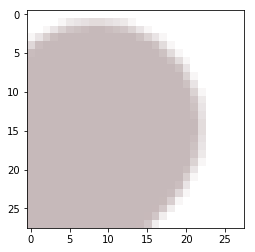

In [14]:
index = np.random.randint(0, X.shape[0])
show_source(index)

In [15]:
encoded = encoder.encode(X[index])
print(encoded)

compressed in 1.0605218410491943 sec
(2, array([0.49498618, 0.36093405, 0.35744056, 0.46738076, 0.2852464 ,
       0.599018  , 0.2694035 , 0.6574114 , 0.83537734], dtype=float32))


decompressed in 2.594597101211548 sec


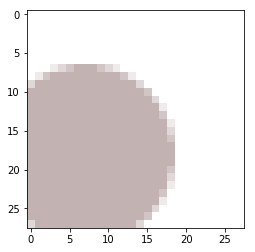

In [16]:
decoder.decode(encoded, size=28)

### COMPRESSION RATIO
$$0,06818 \cdot \frac{size^2}{actions}$$

Stała 0,06818 wynika z założenia reprezentacji obrazka wejściowego przez **3 B/pixel** (RGB) oraz obrazka skompresowanego przez **44 B/action** (4 bajty na numer akcji, 10 razy 4 bajty na argumenty akcji)

Przykładowo dla obrazka 100x100 i 100 akcji **compression ratio = 6,818**     

Skoro compression ratio zależy od ilości wykonanych akcji, istnieje maksymalna wartość, którą możemy użyć, aby skompresowany obrazek był mniejszy od obrazka wejściowego.   
$$maxActions=ceil(0.06818 \cdot size^2-1)$$
Przykładowo:   
obrazek 50x50 = max 170 akcji   
obrazek 100x100 = max 681 akcji        
obrazek 300x300 = max 6136 akcji

Liczbę możliwych do wykonania akcji można nieco zwiększyć poprzez zastosowanie dodatkowej kompresji na wynikowym ciągu wektorów akcji. Użyłam do tego celu gotowego kodera entropijnego wykorzystującego kodowanie arytmetyczne. Ma ono jednak sens jedynie po przekroczeniu pewnej liczby akcji, ponieważ w skompresowanym pliku przechowywana jest między innymi tablica prawdopodobieństw. Dla małych plików (mniej niż 200 akcji, ~ 8kB) kompresja spowoduje więc powstanie większego pliku niż plik wejściowy.
### COMPRESSION SPEED
![compression speed](../result/coding/encoding_time.png)

Relacja ilości akcji do czasu:
$$czas kompresji dla obrazka 100x100 ~ 0.55 \cdot actions + 3.47 [s]$$

![compression speed](../result/coding/encoding_time_size.png)

### DECOMPRESSION SPEED
![compression speed](../result/coding/encoding_time.png)

Relacja ilości akcji do czasu:
$$czas dekompresji dla obrazka 100x100 ~ 0.01 \cdot actions + 2.6 [s]$$

![compression speed](../result/coding/encoding_time_size.png)

Zwiększając liczbę akcji (zmniejszając compression loss) czas kompresji rośnie około 5.5 razy szybciej niż czas dekompresji.

#### Dekompresja do dowolnego rozmiaru

### COMPRESSION LOSS
Za miarę straty kompresji przyjęłam dystans l2:
![euclidean distance](https://wikimedia.org/api/rest_v1/media/math/render/svg/795b967db2917cdde7c2da2d1ee327eb673276c0)


